In [15]:
import torch
import torch.nn as nn
import numpy as np 
import random
import tqdm
import matplotlib.pyplot as plt

In [9]:
device = torch.device("cuda:7")

H = torch.load("test/original_weights.pt")["H"].to(device).float()
weights = torch.load("test/original_weights.pt")["weights"].to(device).float()    

In [10]:
import sklearn.cluster as cluster

In [11]:
def cluster_e_step(X,centriods,
                   weights):
    
    """
    X: torch tensor of the weights, rearanged into a shape of (n, d)
    centriods: torch.tensor of the centriods, shape of (k, d)
    weights: torch.tensor of shape (n,d)
    """

    # k = centriods.shape[0]

    errors = (X.unsqueeze(-1) - centriods.T.unsqueeze(0))**2
    #shape of (n, d, k)

    #multiply by the diagonal
    errors = errors * weights.unsqueeze(-1)

    #sum by the d
    errors = errors.sum(1)
    # print("errors[0,10,:] = ", errors[0,10,:])
    #shape of (n, k)
    # print(errors[0,10,:])
    assignments = errors.argmin(-1)
    # print("assignments[0,10] = ", assignments[0,10])
    # print("="*10)
    #shape of (n)
    return assignments


def cluster_m_step(X, assignments, k, weights):
    """
    X: torch tensor of the weights, rearanged into a shape of (n, d)
    assignments: torch.tensor of the assignments, shape of (n)
    k: int, number of clusters
    weights: torch.tensor of shape (n, d)
    """
    n, d = weights.shape

    #compute the new centriods
    centriods = torch.zeros((k,d), dtype = weights.dtype, device = weights.device)
    #shape of (k,d)
    for i in range(k):
        assignment_X = X[assignments == i] #shape of (n_i,d)
        assignments_weights = weights[assignments == i] #shape of (n_i,d)

        centriods[i] = torch.sum(assignments_weights * assignment_X, dim = 0) / torch.sum(assignments_weights, dim = 0)

    return centriods


def our_cluster(X, k, weights, n_iter = 100,
            centriods = None):
    """
    weights: torch tensor of the weights, rearanged into a shape of (n, d)
    k: int, number of clusters
    weights: torch.tensor of shape (n, d)
    n_iter: int, number of iterations
    """
    n, d = weights.shape

    #randomly select k centriods
    if centriods is None:
        n_1 = torch.from_numpy(np.random.choice(n, k, replace = False)).to(device)
        centriods = X[n_1, :]
        # print(centriods)
    #shape of (k, d)
    for i in range(n_iter):
        # print("X.shape = ", X.shape, "centriods.shape = ", centriods.shape, "weights.shape = ", weights.shape)
        assignments = cluster_e_step(X, centriods, weights)
        # print(assignments)
        # print(assignments.shape)
        centriods = cluster_m_step(X, assignments, k, weights)
        if i > 0:
            if torch.all(assignments == assignments_old):
                # print("breaking at iteration", i)
                break
            # print("n_change:", torch.sum(assignments != assignments_old))
        assignments_old = assignments.clone()
    return assignments, centriods
    

def reconstruct_cluster(assignments, centriods):
    """
    assignments: torch.tensor of the assignments, shape of (n, m/d)
    centriods: torch.tensor of the centriods, shape of (k, d)
    H_diag: torch.tensor of shape (m/d,d)
    """
    reconstructed_X = centriods[assignments,:]
    #shape of (n, m/d, d)
    return reconstructed_X


In [12]:
def bin_entropy(values, bins:int = 100,eps = 1e-5):
    """
    values: torch.tensor of the values
    bins: int, number of bins
    """
    hist = torch.histc(values, bins = bins)
    hist = hist + eps
    hist = hist / hist.sum()
    # print(hist)
    # print(torch.log2(hist))
    entropy = - (hist * torch.log2(hist)).sum()
    return entropy

corresponding fraction of data: 0.732421875 %


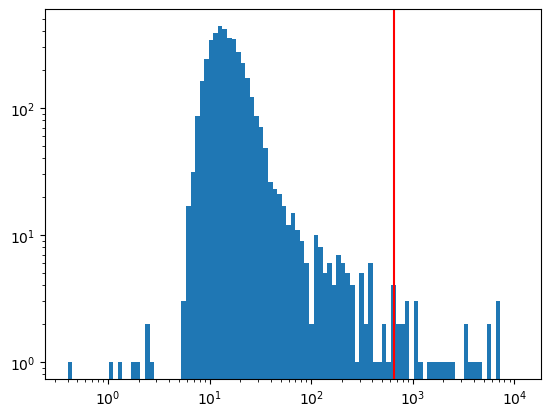

In [30]:
data = torch.norm(H, dim  = 1).cpu().numpy()

#sort the data
data = np.sort(data)

top_n = 30
print("corresponding fraction of data:", 100*top_n/len(data), "%")

threshold = np.argsort(data)[-top_n]

bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 100)
plt.hist(torch.norm(H, dim  = 1).cpu().numpy(), bins = bins)
plt.axvline(data[threshold], color = "red")
plt.xscale("log")
plt.yscale("log")

mask.sum() =  tensor(0.9869, device='cuda:7')
mask_H.sum() =  tensor(0.9934, device='cuda:7')
mask_weights.sum() =  tensor(0.9934, device='cuda:7')


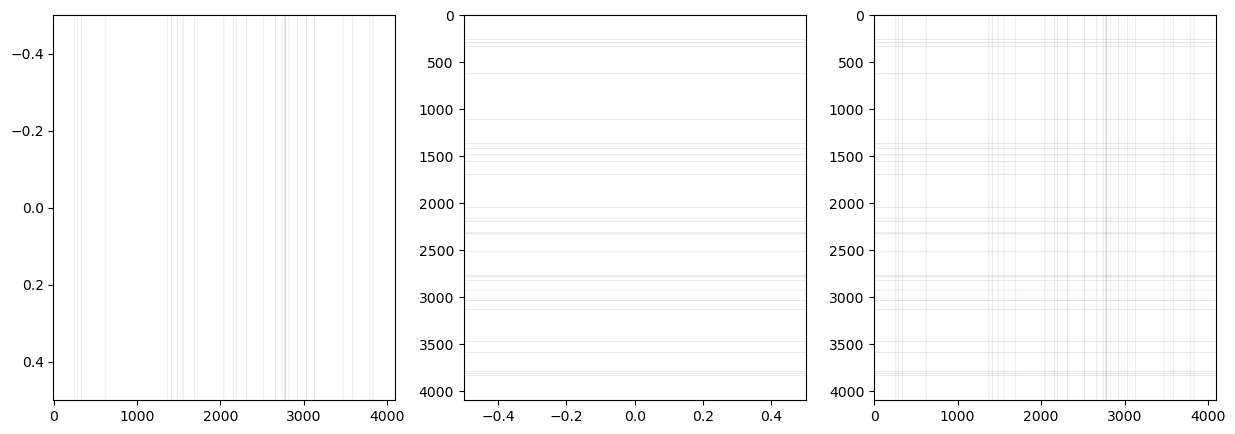

In [47]:
d = 4

percent_dense = 0.75


H_norms = torch.norm(H, dim  = 1)
weight_norms = torch.norm(weights, dim = 0)

# print(-int((percent_dense * len(weight_norms)//d)*d))

threshold_H = torch.sort(H_norms)[0][-int((percent_dense/100 * len(H_norms)//d)*d)]
threshold_weights = torch.sort(weight_norms)[0][-int((percent_dense/100 * len(weight_norms)//d)*d)]

mask_H = H_norms <= threshold_H
mask_weights = weight_norms <= threshold_weights

mask = mask_H.unsqueeze(0) & mask_weights.unsqueeze(1)

print("mask.sum() = ", mask.sum()/mask.numel())
print("mask_H.sum() = ", mask_H.sum()/mask_H.numel())
print("mask_weights.sum() = ", mask_weights.sum()/mask_weights.numel())


fig,axs = plt.subplots(1,3, figsize = (15,5))

axs[0].imshow(mask_H.unsqueeze(0).cpu().numpy(), aspect = "auto", cmap = "gray")
axs[1].imshow(mask_weights.unsqueeze(1).cpu().numpy(), aspect = "auto", cmap = "gray")
axs[2].imshow(mask.cpu().numpy(), aspect = "auto", cmap = "gray")
# plt.imshow(mask.cpu().numpy(), aspect = "auto", cmap = "gray")






In [10]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
import tqdm
import sklearn.cluster

n_iters = 25
d = 4
k_magnitude_codebook = 1
k_coseine_codebook = 16**2
keep_top = 0.01

# print("average bits:", (np.log2(k_magnitude_codebook) + np.log2(k_coseine_codebook))/d)

overhead = k_magnitude_codebook * 16 + k_coseine_codebook * k_magnitude_codebook * 16
sparse_bits = 16* weights.shape[0] * weights.shape[1] * keep_top
encoding_bits = (np.ceil(np.log2(k_magnitude_codebook)) + np.ceil(np.log2(k_coseine_codebook)))/d * weights.shape[0] * weights.shape[1]
print("overhead = ", overhead/(weights.shape[0]*weights.shape[1]), "encoding_bits = ", encoding_bits/(weights.shape[0]*weights.shape[1]), "sparse_bits = ", sparse_bits/(weights.shape[0]*weights.shape[1]))
print("average_bits = ", (encoding_bits+ sparse_bits + overhead)/(weights.shape[0]*weights.shape[1]))
# raise ValueError




subvector_assignments = torch.arange(weights.shape[1]).reshape(-1, d)
# row_assignments = torch.randperm(weights.shape[1]).reshape(-1, d)

assert torch.isfinite(weights).all()
assert torch.isfinite(H).all()

weights_reshaped = weights[:,subvector_assignments] 
print("weights_reshaped.shape = ", weights_reshaped.shape)
#shape of (n, m/d, d)

H_diag = torch.diag(H)[subvector_assignments].unsqueeze(0).expand(weights_reshaped.shape[0], -1, -1)
# H_diag = torch.ones_like(weights_reshaped)
#shape of (n, m/d, d)

weights_norms = torch.norm(weights_reshaped, dim = -1)
# print(H[:,row_assignments].shape)
H_norms = torch.norm(H[:,subvector_assignments], dim = (0,-1))

mask_H = H_norms < torch.quantile(H_norms.float(), 1-keep_top/2)
# print(torch.quantile(H_norms.float(), 1-keep_top/2))
mask_H = mask_H.unsqueeze(0).expand(weights.shape[0], -1)
print(mask_H)
print(weights_norms.shape)
mask_norm = weights_norms < torch.quantile(weights_norms, 1-keep_top/2)
# mask = mask_norm
mask = mask_norm & mask_H

# raise ValueError
# print(torch.quantile(weights_norms, 1-keep_top), torch.max(weights_norms), torch.min(weights_norms))
# print(torch.sum(mask)/(mask.shape[0]*mask.shape[1]), 1 - torch.sum(mask)/(mask.shape[0]*mask.shape[1]))
# raise ValueError
#mask of the top 1% of the weights

weights_norms_masked = weights_norms[mask]
weights_use = weights_reshaped[mask,:]  #/weights_norms_masked.unsqueeze(-1)
H_diag_use = H_diag[mask,:] #* weights_norms_masked.unsqueeze(-1)**2
# H_diag_use = torch.clip(H_diag_use, 0,100)

print("weights_norms_masked.shape", weights_norms_masked.shape)
print("weights_masked.shape = ", weights_use.shape)
print("H_diag_use.shape = ", H_diag_use.shape)


# #first we get the magnitude codebook
# magnitude_assignments, magnitude_codebook = our_cluster(torch.log(weights_norms_masked).unsqueeze(-1), k_magnitude_codebook, 
#                                                         torch.ones_like(weights_norms_masked).unsqueeze(-1),
#                                                          n_iter = 1000)

#try binning the magnitudes
# magnitude_codebook = np.linspace(np.log(weights_norms_masked.min()), np.log(weights_norms_masked.max()), k_magnitude_codebook).reshape(-1,1)
# magnitude_assignments = np.argmin(np.abs(np.log(weights_norms_masked.numpy()).reshape(-1,1) - magnitude_codebook.T), axis = 1)
# print("magnitude_codebook = ", magnitude_codebook)
# print("magnitude_assignments = ", magnitude_assignments)


codebooks = {}
assignments_dict = {}
# for i in tqdm.tqdm(range(k_magnitude_codebook)):
    # mask_i = magnitude_assignments == i
    # if torch.sum(mask_i) <= k_coseine_codebook:
    #     codebooks[i] = weights_use[mask_i,:]
    #     assignments_dict[i] = torch.arange(torch.sum(mask_i).item())
    #     continue

    # assignments, centriods = our_cluster(weights_use[mask_i,:], k_coseine_codebook, H_diag_use[mask_i,:], n_iter = n_iters)

mappings, codebooks = our_cluster(weights_use, k_coseine_codebook, H_diag_use, n_iter = n_iters)



weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
weights_reconstructued_flat[mask,:] = codebooks[mappings,:] 
# for i in range(k_magnitude_codebook):
#     # mask_i = magnitude_assignments == i
#     # mask_ = torch.zeros_like(mask)
#     # mask_[mask] = mask_i
#     # weights_reconstructued_flat[mask_,:] = codebooks[i][assignments_dict[i],:] #* torch.exp(magnitude_codebook[i,0])
#     weights_reconstructued_flat[mask,:] = codebooks[mappings,:] 
# weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()


weights_reconstructued = torch.empty_like(weights)

weights_reconstructued[:,subvector_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)


diff = weights - weights_reconstructued

average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

print(f"average error {average_error}, H error {H_error}")

overhead =  0.00024509429931640625 encoding_bits =  2.0 sparse_bits =  0.16
average_bits =  2.1602450942993165
weights_reshaped.shape =  torch.Size([4096, 1024, 4])
tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:7')
torch.Size([4096, 1024])
weights_norms_masked.shape torch.Size([4151705])
weights_masked.shape =  torch.Size([4151705, 4])
H_diag_use.shape =  torch.Size([4151705, 4])
average error 0.3755868673324585, H error 3.049225330352783


In [11]:
mappings

tensor([  8,  38,  74,  ..., 191, 227, 180], device='cuda:7')

In [12]:
codebooks

tensor([[ 0.0359, -0.0032, -0.0125, -0.0033],
        [ 0.0078,  0.0001,  0.0621,  0.0556],
        [-0.0169,  0.0284,  0.0029, -0.0169],
        ...,
        [ 0.0681,  0.0369, -0.0083, -0.0290],
        [-0.0139, -0.0035, -0.0118, -0.0044],
        [-0.0277, -0.0253,  0.0370,  0.0152]], device='cuda:7')

In [13]:
H[~torch.isfinite(H)]

tensor([], device='cuda:7')

In [14]:

codebooks_use = codebooks.clone().requires_grad_(True)


n_iters = 100
lr = 1e-3
clamp_gradients = 1e-1
prev_loss = 1e10

for i in range(n_iters):
    weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

    weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
    # print(codebooks_use[0])
    # for i in range(k_magnitude_codebook):
    #     mask_i = torch.from_numpy(magnitude_assignments == i)
    #     assert torch.any(mask_i)
    #     mask_ = torch.zeros_like(mask)
    #     mask_[mask] = mask_i
    weights_reconstructued_flat[mask,:] = codebooks_use[mappings,:]
    # weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()


    weights_reconstructued = torch.empty_like(weights)

    weights_reconstructued[:,subvector_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)
    # print(weights_reconstructued)

    diff = weights - weights_reconstructued
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
    print(f"average error {average_error}, H error {H_error}")
    H_error.backward()

    if H_error > prev_loss:
        lr = lr/2
        print("reducing lr to ", lr)
    prev_loss = H_error.item()
    with torch.no_grad():

        codebooks_use.grad = torch.clamp(codebooks_use.grad, -clamp_gradients, clamp_gradients)
        codebooks_use -= lr * codebooks_use.grad
        codebooks_use.grad.zero_()

average error 0.3755868673324585, H error 3.049225330352783
average error 0.3758241534233093, H error 3.0040173530578613
average error 0.3761034905910492, H error 2.9621713161468506
average error 0.37642237544059753, H error 2.9236814975738525
average error 0.3767775595188141, H error 2.8885326385498047
average error 0.3771657943725586, H error 2.8567042350769043
average error 0.37758132815361023, H error 2.828172445297241
average error 0.378013551235199, H error 2.802896022796631
average error 0.378436416387558, H error 2.780755043029785
average error 0.37881678342819214, H error 2.7612900733947754
average error 0.37915199995040894, H error 2.7438955307006836
average error 0.3794507086277008, H error 2.727942705154419
average error 0.3797306418418884, H error 2.713062286376953
average error 0.3800008296966553, H error 2.6990742683410645
average error 0.3802667558193207, H error 2.6858787536621094
average error 0.3805312216281891, H error 2.6733956336975098
average error 0.380798667669

In [15]:
# import pca
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 2)

#perform a pca on the weights
weights_pca = pca.fit_transform(weights_use.cpu().numpy())

#transform the old codebooks and the new codebooks
codebooks_pca = pca.transform(codebooks_use.cpu().detach().numpy())
codebooks_old_pca = pca.transform(codebooks.cpu().numpy())

outliers_pca = pca.transform(weights_reshaped[~mask_norm,:].cpu().numpy())
H_large_pca = pca.transform(weights_reshaped[~mask_H,:].cpu().numpy())

#plot out countour plot of the weights
import matplotlib.pyplot as plt
import seaborn as sns


KeyboardInterrupt: 

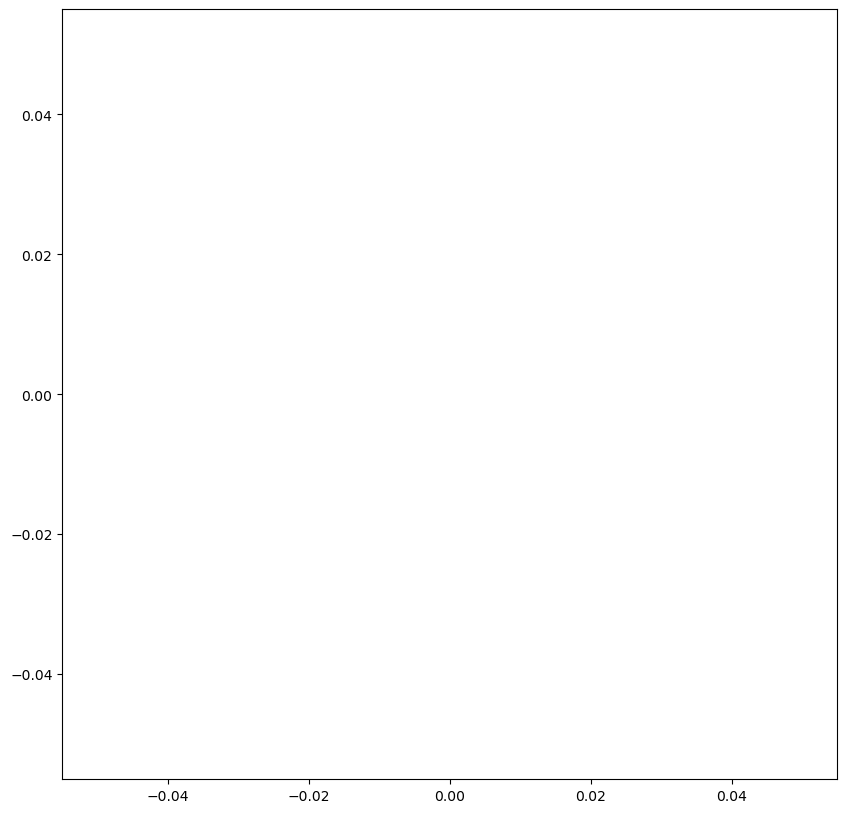

In [17]:
#plot out countour plot of the weights
import matplotlib.pyplot as plt
import seaborn as sns

n_plot = 40000
indicies = np.random.choice(weights_pca.shape[0], n_plot, replace = False)

plt.figure(figsize=(10,10))
sns.kdeplot(x=weights_pca[indicies,0], y=weights_pca[indicies,1], fill = True)

plt.scatter(codebooks_pca[:,0], codebooks_pca[:,1], c = 'r', label = "new codebooks", s = 10)
plt.scatter(codebooks_old_pca[:,0], codebooks_old_pca[:,1], c = 'g', label = "old codebooks",
            s = 10)

#draw arrrows between the old and new codebooks
for i in range(codebooks_pca.shape[0]):
    plt.arrow(codebooks_old_pca[i,0], codebooks_old_pca[i,1], codebooks_pca[i,0] - codebooks_old_pca[i,0],
              codebooks_pca[i,1] - codebooks_old_pca[i,1], head_width=0.005, head_length=0.005, fc='k', ec='k')

# plt.scatter(outliers_pca[:,0], outliers_pca[:,1], c = 'y', label = "outliers", s = 1, alpha = 0.5)
# plt.scatter(H_large_pca[:,0], H_large_pca[:,1], c = 'b', label = "H large", s = 1, alpha = 0.5)
plt.legend()
plt.title("Weights distribution")

In [11]:


soft_one_hot_value = 5
# for i in range(k_magnitude_codebook):
    # if codebooks[i].shape[0] < k_coseine_codebook:
    #     continue
codebooks_use = codebooks.clone().requires_grad_(True)



mappings_use_ = torch.zeros((k_coseine_codebook, mappings.shape[0]), dtype = codebooks_use.dtype, device = codebooks.device)
# print(assignments_dict[i].shape)
mappings_use_[mappings, torch.arange(mappings.shape[0])] = soft_one_hot_value

mappings_use_ = mappings_use_.clone().requires_grad_(True)
# raise ValueError
# magnitude_codebook_use = magnitude_codebook[:,0].clone()
n_iters = 100
lr = 1e-3
lr_map = 1e-3
clamp_gradients = 1e-1
prev_loss = 1e10

lambda_ = 0.1
betas = np.linspace(8,1, n_iters)

losses = []
 
for iters in range(n_iters):
    beta = betas[iters]

    weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

    weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
    # print(codebooks_use[0])

    regularization_loss = 0 

    assignments_ = torch.softmax(mappings_use_, dim = 0)
    # raise ValueError
    # print(assignments_.shape)
    # print(codebooks_use[i].shape)
    # weights_reconstructued_flat[mask_,:] = codebooks_use[i][assignments_dict[i],:]
    regularization_loss = torch.sum(1 - torch.abs(2*assignments_ - 1)**beta)
    # weights_reconstructued_flat[mask_,:] = torch.clip(codebooks_use[i][assignments_dict[i],:],-1,1) * torch.exp(magnitude_codebook_use[i])
    weights_reconstructued_flat[mask,:] = assignments_.T @ codebooks_use



    weights_reconstructued = torch.empty_like(weights)

    weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)
    # print(weights_reconstructued)

    diff = weights - weights_reconstructued
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)


    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

    loss = H_error + lambda_ * regularization_loss
    print(f"average error {average_error}, H error {H_error}, regularization_loss = {regularization_loss}")
    loss.backward()
    losses.append(H_error.item())
    if H_error > prev_loss:
        lr = lr * 0.9
        print("reducing lr to ", lr)
    prev_loss = H_error.item()
    with torch.no_grad():
        # codebooks_use.grad = torch.clamp(codebooks_use.grad, -clamp_gradients, clamp_gradients)
        # codebooks_use -= lr * codebooks_use.grad
        # codebooks_use.grad.zero_()
        # print(mappings_use_.grad)
        mappings_use_.grad = torch.clamp(mappings_use_.grad, -clamp_gradients, clamp_gradients)
        mappings_use_ -= lr_map * mappings_use_.grad
        mappings_use_.grad.zero_()
        codebooks_use.grad.zero_()
        # magnitude_codebook_use -= torch.clip(lr * magnitude_codebook_lr_mult * magnitude_codebook_use.grad, -clamp_gradients*magnitude_codebook_lr_mult, clamp_gradients*magnitude_codebook_lr_mult)
        # magnitude_codebook_use.grad = None



average error 0.45272842049598694, H error 8.723808288574219, regularization_loss = 18361468.0
average error 0.45272859930992126, H error 8.72304916381836, regularization_loss = 18237976.0
average error 0.4527287185192108, H error 8.72229290008545, regularization_loss = 18114116.0
average error 0.45272889733314514, H error 8.721476554870605, regularization_loss = 17989760.0
average error 0.45272907614707947, H error 8.72071647644043, regularization_loss = 17865062.0
average error 0.4527292549610138, H error 8.719961166381836, regularization_loss = 17739884.0
average error 0.4527294337749481, H error 8.719202995300293, regularization_loss = 17614298.0
average error 0.45272961258888245, H error 8.718391418457031, regularization_loss = 17488246.0
average error 0.452729731798172, H error 8.717632293701172, regularization_loss = 17361786.0
average error 0.4527299106121063, H error 8.716875076293945, regularization_loss = 17234872.0
average error 0.45273008942604065, H error 8.71611976623535

In [12]:
assignments_[:,0]

tensor([0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.9090, 0.0061, 0.0061, 0.0061,
        0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061, 0.0061],
       device='cuda:6', grad_fn=<SelectBackward0>)

In [56]:
assignments_new = {i: assignments_use[i].argmax(0) for i in assignments_use}

weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
# print(codebooks_use[0])

with torch.no_grad():

    regularization_loss = 0
    for i in range(k_magnitude_codebook):
        mask_i = magnitude_assignments == i
        assert torch.any(mask_i)
        mask_ = torch.zeros_like(mask)
        mask_[mask] = mask_i
        if i not in codebooks_use:
            weights_reconstructued_flat[mask_,:] = codebooks[i][assignments_dict[i],:] * torch.exp(magnitude_codebook_use[i])
            continue    

        weights_reconstructued_flat[mask_,:] = torch.clip(codebooks_use[i][assignments_new[i],:],-1,1) * torch.exp(magnitude_codebook_use[i])
    # weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()


    weights_reconstructued = torch.empty_like(weights)

    weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)
    # print(weights_reconstructued)

    diff = weights - weights_reconstructued
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)


H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

loss = H_error + lambda_ * regularization_loss
print(f"average error {average_error}, H error {H_error}")

average error 0.5536376237869263, H error 5.610358715057373


In [57]:
n_change = 0
for i in codebooks_use:

    n_change += torch.sum(assignments_new[i] != assignments_dict[i])

print("n_change = ", n_change)

n_change =  tensor(0, device='cuda:6')


In [58]:
assignments_dict[0]

tensor([15, 11,  1,  ...,  2,  8,  9], device='cuda:6')

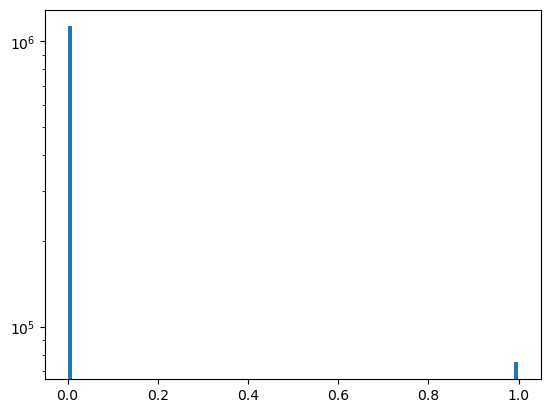

In [59]:
plt.hist(assignments_.detach().cpu().numpy().flatten(), bins = 100)
plt.yscale('log')

In [61]:
assignments_use[0][assignments_dict[0],:].detach().cpu().numpy()

array([[ 9.9999952e+00,  1.2635506e-07,  1.5326428e-07, ...,
        -5.7824224e-08, -1.2287417e-07, -4.6445859e-08],
       [ 1.1943567e-07,  9.9999952e+00,  9.9999924e+00, ...,
        -5.9382781e-08,  1.0000002e+01, -4.4714639e-08],
       [ 1.1943567e-07,  9.9999952e+00,  9.9999924e+00, ...,
        -5.9382781e-08,  1.0000002e+01, -4.4714639e-08],
       ...,
       [ 5.5878967e-08,  6.5669362e-08,  7.8594709e-08, ...,
         1.0000001e+01, -6.2216365e-08, -4.7712575e-08],
       [ 1.1943567e-07,  9.9999952e+00,  9.9999924e+00, ...,
        -5.9382781e-08,  1.0000002e+01, -4.4714639e-08],
       [ 5.4991109e-08,  6.7893268e-08,  8.2246736e-08, ...,
        -6.4254273e-08, -6.5741027e-08,  1.0000002e+01]], dtype=float32)

In [62]:
codebooks[i][assignments_dict[i],:]

tensor([[ 4.3442e-02, -4.5606e-02,  7.5983e-02,  ...,  1.2069e-02,
          7.2188e-02,  1.0297e-04],
        [ 4.3442e-02, -4.5606e-02,  7.5983e-02,  ...,  1.2069e-02,
          7.2188e-02,  1.0297e-04],
        [ 4.3442e-02, -4.5606e-02,  7.5983e-02,  ...,  1.2069e-02,
          7.2188e-02,  1.0297e-04],
        ...,
        [-1.5629e-01,  1.7860e-01, -4.9690e-02,  ..., -1.5907e-01,
          2.4043e-02,  4.6148e-02],
        [-1.3026e-01,  3.9753e-02, -6.5690e-02,  ..., -5.2088e-02,
         -3.5687e-01,  9.4983e-02],
        [ 2.4803e-02, -3.7862e-01,  2.0537e-01,  ..., -2.6397e-02,
         -9.8013e-02, -3.7012e-02]], device='cuda:6')

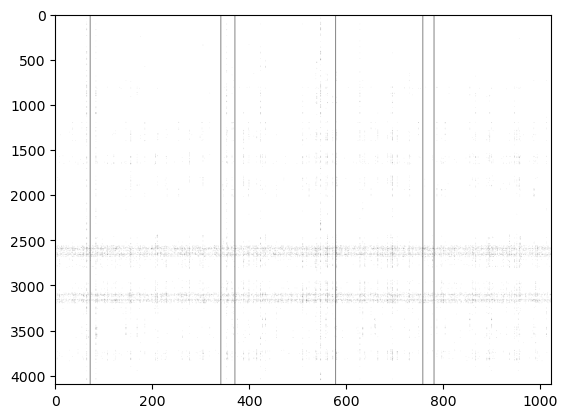

In [18]:
plt.imshow(mask.cpu().numpy(),aspect = 'auto', cmap = 'gray')

Text(0.5, 1.0, 'Hessian Mask')

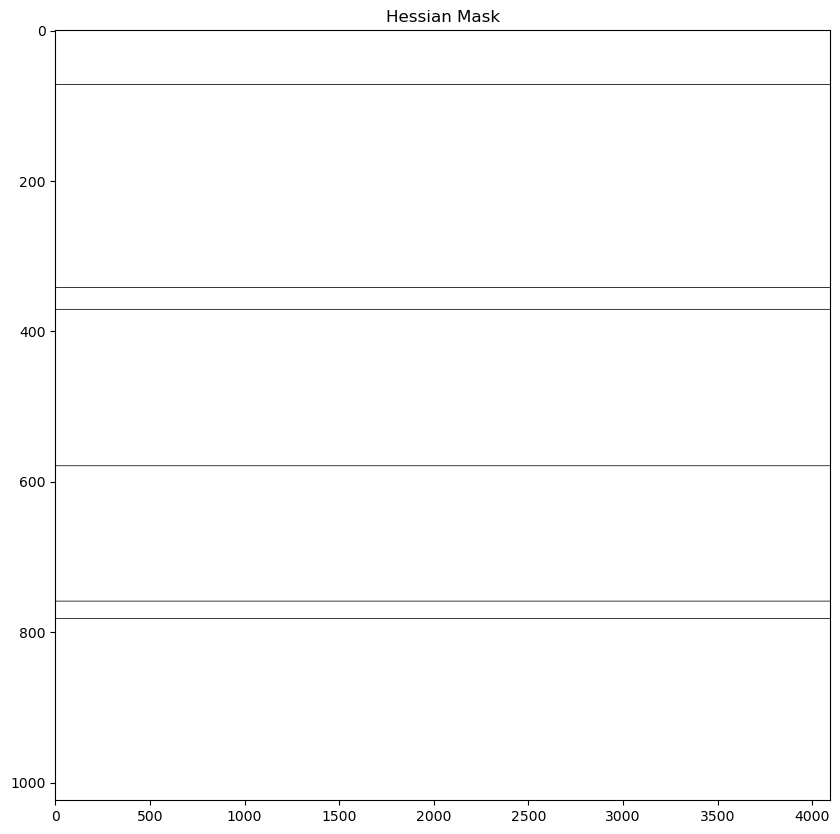

In [24]:
plt.figure(figsize = (10,10))
plt.imshow(mask_H.T.cpu().numpy(),aspect = 'auto', cmap = 'gray')
plt.title("Hessian Mask")

Text(0.5, 1.0, 'Norm Mask')

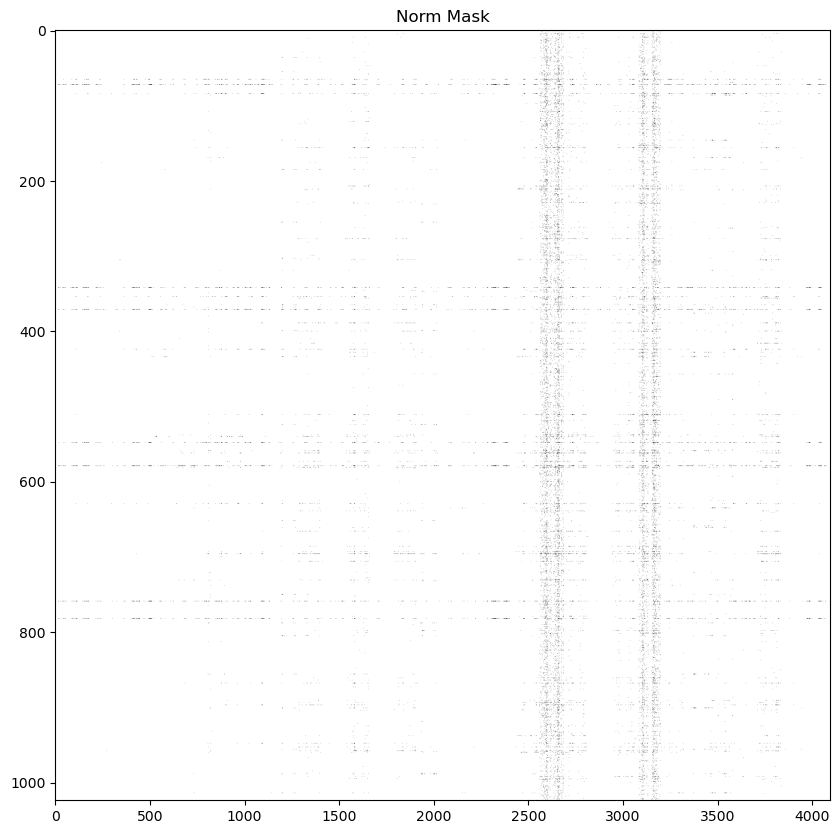

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(mask_norm.T.cpu().numpy(),aspect = 'auto', cmap = 'gray')
plt.title("Norm Mask")

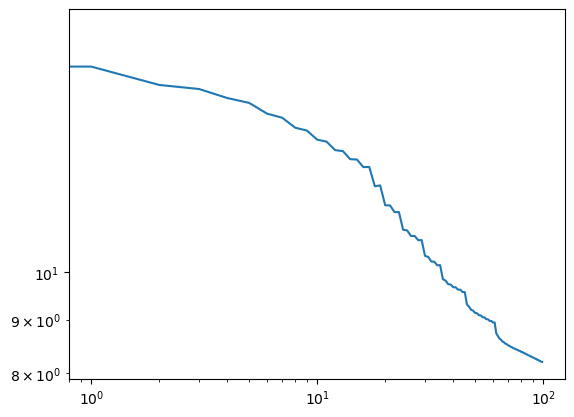

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.yscale("log")
plt.xscale("log")